# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Diffusion-of-Social-Innovations-in-a-Global-Online-Social-Network-Targeting-Chronic-Disease" data-toc-modified-id="Diffusion-of-Social-Innovations-in-a-Global-Online-Social-Network-Targeting-Chronic-Disease-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Diffusion of Social Innovations in a Global Online Social Network Targeting Chronic Disease</a></div><div class="lev2 toc-item"><a href="#Exhibit-1:" data-toc-modified-id="Exhibit-1:-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exhibit 1:</a></div><div class="lev2 toc-item"><a href="#Exhibit-2:-connections-and-nodes-provided-in" data-toc-modified-id="Exhibit-2:-connections-and-nodes-provided-in-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Exhibit 2: connections and nodes provided in</a></div><div class="lev1 toc-item"><a href="#Supplemental-Exhibit-1" data-toc-modified-id="Supplemental-Exhibit-1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Supplemental Exhibit 1</a></div>

In [1]:
from mpl_toolkits.basemap import Basemap
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import pysal as ps
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
import matplotlib.font_manager as fm
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import pyproj as pyproj
import fiona
from itertools import chain
%matplotlib inline
from IPython.core.pylabtools import figsize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
from shapely.prepared import prep
import seaborn as sns

import ast
from adjustText import adjust_text
figsize(11,9)

from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Diffusion of Social Innovations in a Global Online Social Network Targeting Chronic Disease

In [17]:
# import data on registered users
data = pd.read_csv('data/registered_users.csv')

## Exhibit 1: 

/usr/local/lib/python3.6/site-packages/pandas/tools/plotting.py:983: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


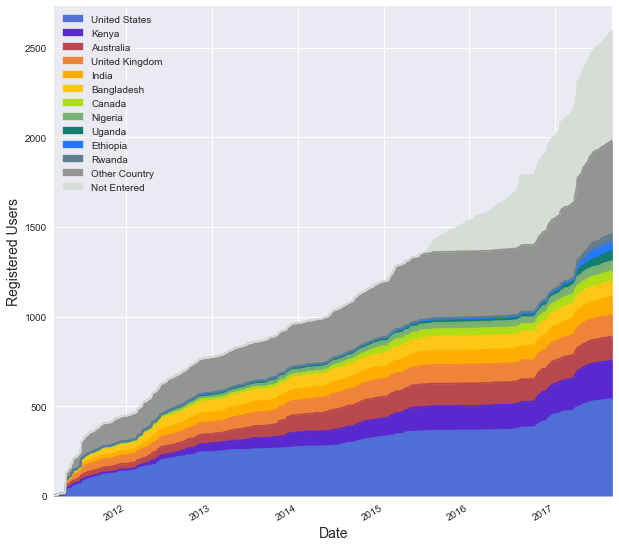

In [2]:
# Growth over time
data['created_at'] = pd.to_datetime(data['created_at'])
data['created_at_year_mo'] = list(zip(data['created_at'].dt.year, data['created_at'].dt.month))
data['created_at_mo_day'] = list(zip(data['created_at'].dt.month, data['created_at'].dt.day))

data = data.sort_values(by='created_at')

countries = ['United States', 'Kenya', 'Australia', 'United Kingdom', 'India', 'Bangladesh', 'Canada', 'Nigeria', 'Uganda', 'Ethiopia', 'Rwanda']

# to save names for plotting
col_list = []

# for renaming columns
country_dict = {}

for country in countries:
    underscored = '_'.join(country.lower().split(' '))
    data[underscored] = (data.primary_country == country).apply(lambda x: int(x))
    data[underscored + '_cumsum'] = data[underscored].cumsum()
    col_list.append(underscored + '_cumsum')
    country_dict[underscored + '_cumsum'] = country
    

data['not_entered'] = data.primary_country.isnull()
data['not_entered_cumsum'] = data.not_entered.cumsum()
country_dict['not_entered_cumsum'] = 'Not Entered'
    

data['other_country'] = data.not_entered | data.united_states | data.kenya | data.australia | data.united_kingdom | data.india | data.bangladesh | data.canada | data.nigeria | data.uganda | data.ethiopia
data['other_country'] = data.other_country.apply(lambda x: not x)
data['other_country_cumsum'] = data.other_country.cumsum()
col_list.append('other_country_cumsum')
country_dict['other_country_cumsum'] = 'Other Country'
countries.append('Other Country')
countries.append('Not Entered')
    
col_list.append('not_entered_cumsum')

fig, ax = plt.subplots()
plot_data = data.rename(index=str, columns=country_dict)

# selected colors for chart
colors = ["cornflower blue", "blue purple", "dusty red", "dusty orange", "orange yellow", "golden yellow", "yellowish green",  
          "faded green", "blue green", "clear blue", "blue grey", 'grey', "light grey"]

# making stacked bar chart
plot_data.set_index('created_at')[countries].plot.area(colors= sns.xkcd_palette(colors), figsize=(10,10), ax=ax)

ax.set_ylabel('Registered Users',fontsize=14)
ax.set_xlabel('Date',fontsize=14)

plt.savefig('exhibits/exhibit1_stackedbar.png',bbox_inches='tight', dpi=300)

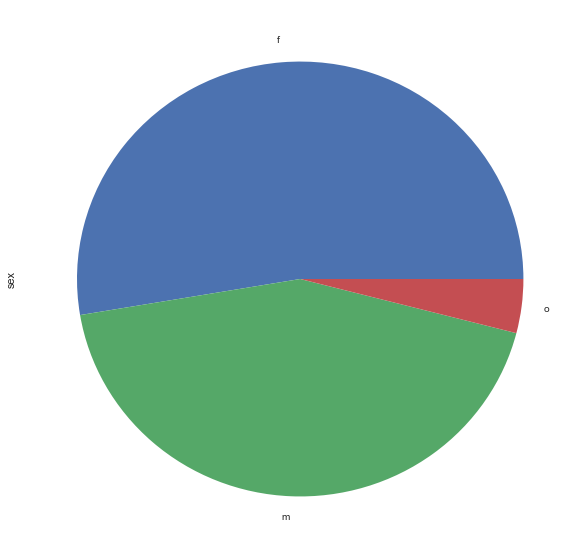

In [3]:
fig, ax = plt.subplots()
data.sex.value_counts().plot.pie(ax=ax, figsize=(10,10))
plt.savefig('exhibits/exhibit1_sex.png',dpi=300, bbox_inches='tight')

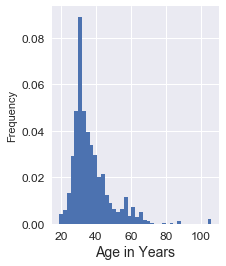

In [9]:
# Age 
from datetime import datetime
data_age = data[data.born_at.notnull()]
data_age = data_age[data_age.born_at.apply(lambda x: len(x) == len('07/30/1985'))]
data_age['yob'] = data_age.born_at.apply(lambda x: datetime.strptime(str(x), '%m/%d/%Y').year)
data_age['age'] = 2017 - data_age['yob'].apply(lambda x: int(x))

figsize=(4, 10)
fig, ax = plt.subplots()
data_age.age.plot.hist(bins=40, normed=True, ax=ax, histtype='bar', figsize=(3,4), fontsize=12)
ax.set_xlabel('Age in Years', fontsize=14)
plt.savefig('exhibits/exhibit1_age.png',bbox_inches='tight',dpi=300)

In [10]:
data_age.age.describe()

count    841.000000
mean      37.167658
std       11.294719
min       19.000000
25%       30.000000
50%       34.000000
75%       41.000000
max      106.000000
Name: age, dtype: float64

In [23]:
# Tagged Interests
data = pd.read_csv('data/registered_users.csv')
data['tag_list'] = data['tag_list'].apply(lambda x: x.split(',') if type(x) == str else None)
data['tag_list'] = data['tag_list'].apply(lambda x: [i.strip() for i in x] if type(x) == list else None)
all_tags = pd.Series([i.strip() for i in data.tag_list.dropna().sum()]).unique()

for tag in all_tags:
    data[tag] = data['tag_list'].apply(lambda x: int(tag in x) if x != None else 0) * 1

# this table is filtered by hand for spurious (location) tags
    
data[all_tags].sum().to_frame(name='num_members').sort_values(by='num_members', ascending=False).to_csv('exhibits/exhibit1_tags.csv')

## Exhibit 2: connections and nodes provided in 

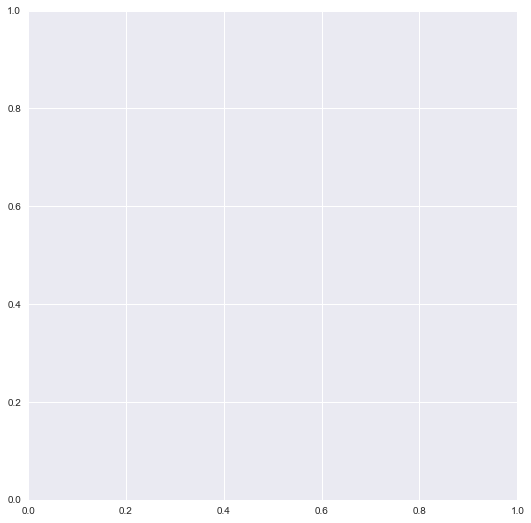

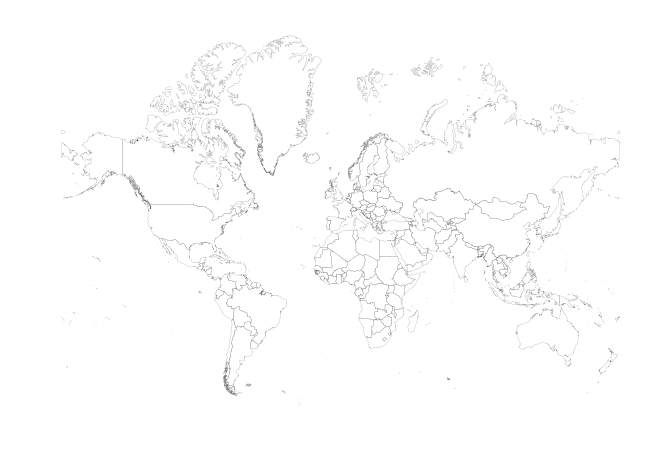

In [4]:
# make empty world map
fig, ax = plt.subplots()
ax.set_aspect('equal')
gdf = gpd.GeoDataFrame.from_file('shapefiles/TM_WORLD_BORDERS-0.3.shp')
gdf = gdf[gdf.NAME != 'Antarctica']
crs = gdf.crs

fig, ax = plt.subplots()
ax.set_aspect('equal')

# get ready to plot df_members as choropleth
gdf['geometry'] = gdf.geometry.to_crs(epsg=3395)
gdf.plot(facecolor='#FFFFFF',linewidth=0.1, ax=ax)
_ = ax.axis('off')

plt.savefig('exhibits/exhibit2_blank.png', bbox_inches='tight', dpi=300)

# Supplemental Exhibit 1

In [25]:
gdf = gpd.GeoDataFrame.from_file('shapefiles/TM_WORLD_BORDERS-0.3.shp')
gdf = gdf[gdf.NAME != 'Antarctica']

iso3_codes = pd.read_csv('iso2_3.csv')
iso2_3_dict = pd.read_csv('iso2_3.csv').set_index('iso2')['iso3'].to_dict()
iso3_lat_lon_df = pd.read_csv('iso_lat_lon.csv', encoding = "ISO-8859-1")[['country_name','iso3','lat','lon']]
iso3_lat_lon_df['lat_lon'] = list(zip(iso3_lat_lon_df.lat, iso3_lat_lon_df.lon))
iso3_lat_lon_dict = iso3_lat_lon_df.set_index('iso3')['lat_lon'].to_dict()
name_iso3_dict = pd.read_csv('iso_lat_lon.csv', encoding = "ISO-8859-1").set_index('country_name')['iso3'].to_dict()

In [44]:
cols = ['nationbuilder_id','full_name','primary_country_code','primary_country','email','mobile_number','phone_number', 'created_at']

df_yes_country = pd.read_csv('data/located_registered_users.csv', usecols=cols)

df_members = df_yes_country.primary_country_code.value_counts().to_frame()
df_members.columns = ['total_members']
df_members['ISO2'] = df_members.index
df_members['ISO3'] = df_members.ISO2.apply(lambda x: iso2_3_dict[x])
df_members['lat_long'] = df_members.ISO3.apply(lambda x: iso3_lat_lon_dict[x])

df_usage = pd.read_csv('data/sessions_20160701-20170726.csv', skiprows=5, encoding = "ISO-8859-1")
df_usage = df_usage[df_usage.Country != '(not set)']
df_usage = df_usage[df_usage.Country.notnull()]
df_usage.Sessions = df_usage.Sessions.apply(lambda x: int(x.replace(',','')))
df_usage['ISO3'] = df_usage.Country.apply(lambda x: name_iso3_dict[x])
df_usage['lat_long'] = df_usage.ISO3.apply(lambda x: iso3_lat_lon_dict[x])

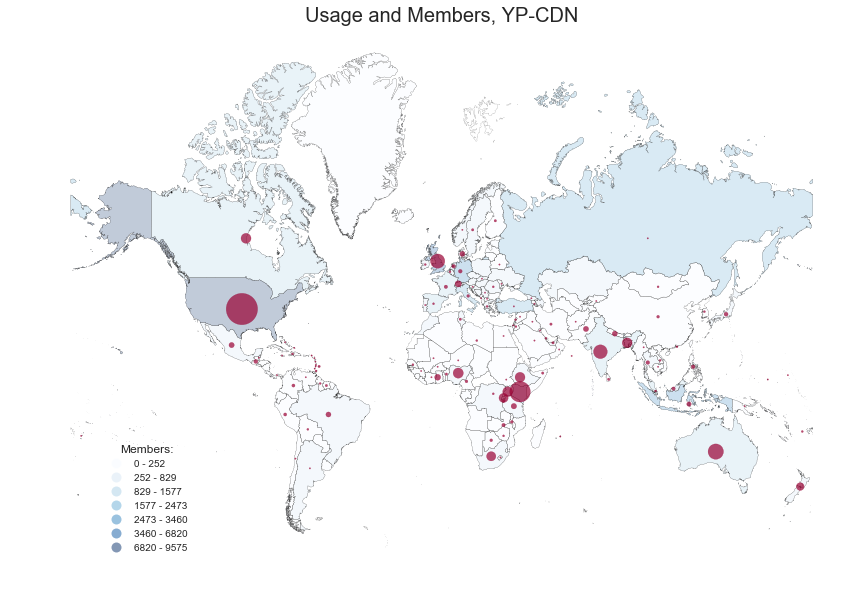

In [45]:
gdf = gpd.GeoDataFrame.from_file('shapefiles/TM_WORLD_BORDERS-0.3.shp')
gdf = gdf[gdf.NAME != 'Antarctica']
crs = gdf.crs

fig, ax = plt.subplots(figsize = (16,10))
ax.set_aspect('equal')

# get ready to plot df_members as choropleth
df_usage = gdf.merge(df_usage, on='ISO3')
df_usage['geometry'] = df_usage.geometry.to_crs(epsg=3857) # setup world projection
df_usage.plot(cmap='Blues', scheme='fisher_jenks', column='Sessions', k=7, ax=ax, linewidth=0.1, legend=True)

gdf['geometry'] = gdf.geometry.to_crs(epsg=3857)
gdf.plot(facecolor='#FFFFFF',linewidth=0.1, ax=ax)

geometry = [Point(xy) for xy in zip(df_members.lat_long.apply(lambda x: x[1]), df_members.lat_long.apply(lambda x: x[0]))]
df_members_points = GeoDataFrame(df_members, crs=crs, geometry=geometry)

df_members_points['geometry'] = df_members_points.geometry.to_crs(epsg=3857)
df_members_points.geometry.plot(marker='o', alpha=0.7, color='#990033', markersize=df_members_points.total_members * 2, ax=ax)

ax.set_title('Usage and Members, YP-CDN', fontsize=20)
_ = ax.axis('off')

leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.2, 0.25))
leg.set_title('Members:')

# nifty script to get rid of extra .00
for t in leg.get_texts():
    t.set_text(t.get_text().replace('.00',''))

plt.savefig('exhibits/exhibit_s1.png', bbox_inches='tight', dpi=200)

plt.show()